# Generate_APWPs.py

This notebook allows apparent polar wander paths to be generated from dataframes of paleomagnetic poles and virtual geomagnetic poles, as returned by the build_compilation notebook.

In [1]:
import os
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
from collections import Counter
import scripts.auxiliar as aux

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
from cartopy.geodesic import Geodesic
from shapely.geometry import Polygon

pd.set_option('display.max_columns', None)

### Import data compilation
Import compilation made with the build_compilation notebook.

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/vgp_database/compilations'
files_names = aux.get_files_in_directory(data_path_VGP)

xlsx_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.xlsx')]
paths = [file for file in files_names if file.endswith('.xlsx')] 
df_files = pd.DataFrame({'path': paths, 'name': xlsx_file_names})
df_files[['name']]

,name
0,test_compilation


Select a compilation to work with

In [3]:
file_idx = 0

<em> This next block will need to be revised according to how we decide to structure the compiled pole/vgp dataframes </em>

In [4]:
df_poles = pd.read_excel(df_files['path'][file_idx], sheet_name='poles')
df_vgps = pd.read_excel(df_files['path'][file_idx], sheet_name='vgps')

#cast columns
df_poles = df_poles.astype({'pole': int, 'N': int, 'Plat':float, 'Plon':float, 'A95':float, 'mean_age':float})
df_vgps = df_vgps.astype({'rev_VGP_lat':float, 'rev_VGP_lon':float, 'mean_age':float})

# APWP construction:
In the following, we compute APWPs according to three different approaches (<em>although can also add splines...</em>):
##### <em> 1. Moving average using poles </em>
##### <em> 2. Moving average using parametrically resampled poles </em>
##### <em> 3. Moving average using original VGPs (site-level data) </em>

## 1. Moving average using study-level poles

First have a look at the data

In [5]:
df_poles.head()

,pole,name,slat,slon,N,dec,inc,k,alpha95,f_corr,Plat,Plon,K,A95,dp,dm,mean_age,min_age,2sig_min,max_age,2sig_max,uncer_dist,rock_typ_1,rock_typ_2,rock_typ_3,R1,R2.1,R2.2,R3,R4,R5.1,R5.2,R6,R7,pmag_ref,age_ref,pmag_comments,age_comments,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42
0,0,Absaroka_volcanics,NaN,NaN,32,NaN,NaN,NaN,NaN,NaN,-83.009618,356.087706,13.553640,7.165544,NaN,NaN,48.5000,48.00,NaN,49.000,NaN,uniform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Beaver_River_intrusions,60.238151,234.652209,21,NaN,NaN,NaN,NaN,NaN,-79.313242,327.669841,44.972756,4.792312,NaN,NaN,42.0000,41.00,NaN,43.000,NaN,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Bighorn_Basin_sediments,44.459816,251.809627,59,NaN,NaN,NaN,NaN,NaN,-81.551190,2.791725,10.647495,5.952536,NaN,NaN,55.8885,52.54,NaN,59.237,NaN,uniform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Bitterroot_Dome_intrusions,46.214352,245.721890,15,NaN,NaN,NaN,NaN,NaN,-80.443193,44.903422,6.598306,16.118493,NaN,NaN,50.9500,46.40,NaN,55.500,NaN,uniform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Central_Mexico_Plio-Pleistocene,19.551706,260.398840,13,NaN,NaN,NaN,NaN,NaN,-88.460021,151.905040,61.445132,5.330717,NaN,NaN,2.6650,0.00,NaN,5.330,NaN,uniform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Sort data by mean age and assign a corresponding index which will be useful later

In [6]:
df_poles.sort_values(by='mean_age', ascending=True, inplace=True)
df_poles.reset_index(drop=True, inplace=True)
df_poles['AgeIdx'] = np.arange(df_poles.shape[0])

### Plot the poles
Have a look at the plotted data.

In [7]:
def plot_poles (df, plon, plat, A95, clr_scaling, size_scaling, extent, plot_A95s=True, connect_poles=False):
    #plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))
    proj = ccrs.Orthographic(central_longitude=0, central_latitude=-55) #30, -60
    ax = plt.axes(projection=proj)    
    ax.stock_img()
    ax.coastlines(linewidth=1, alpha=0.5)
    ax.gridlines(linewidth=1)
    
    cmap = mpl.cm.get_cmap('viridis')

    # plot the A95s
    if plot_A95s:
        norm = mpl.colors.Normalize(df[clr_scaling].min(), df[clr_scaling].max())
        df['geom'] = df.apply(lambda row: Polygon(Geodesic().circle(lon=row[plon], lat=row[plat], radius=row[A95]*111139, n_samples=360, endpoint=True)), axis=1)
        for idx, row in df.iterrows():
            ax.add_geometries([df['geom'][idx]], crs=ccrs.PlateCarree().as_geodetic(), facecolor='none', edgecolor=cmap(norm(df[clr_scaling][idx])), 
                              alpha=0.6, linewidth=1)
        df_poles.drop(['geom'], axis=1)

    # plot the mean poles
    if not size_scaling == None:
        sns.scatterplot(x = df[plon], y = df[plat], hue = df[clr_scaling], palette=cmap, size = df[size_scaling], sizes=(50, 200),
                        transform = ccrs.PlateCarree(), zorder=4)
    else:
        sns.scatterplot(x = df[plon], y = df[plat], hue = df[clr_scaling], palette=cmap, s=50, transform = ccrs.PlateCarree(), zorder=4)
    
    if connect_poles:
        plt.plot(df[plon], df[plat], transform = ccrs.Geodetic(), color='red', linewidth=2.0)

    if extent != 'global':
        ax.set_extent(extent, crs = ccrs.PlateCarree())

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels))
    plt.show()

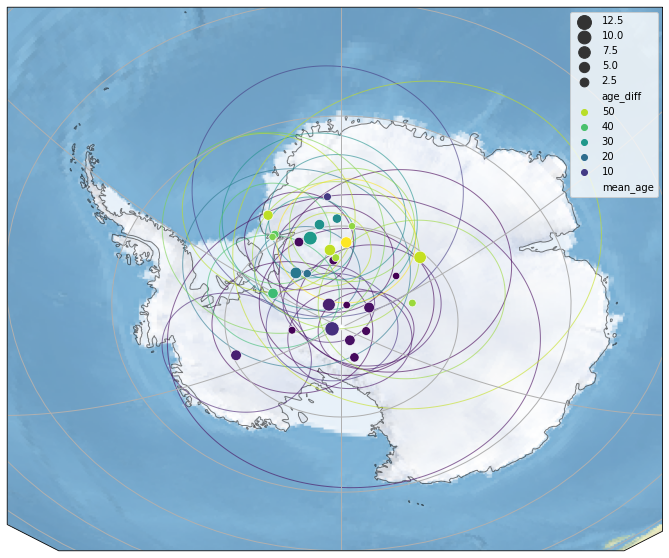

In [8]:
df_poles['age_diff'] = df_poles.apply(lambda row: row.max_age - row.min_age, axis=1)
extent = (-180,180,-60,-90)
plot_poles(df_poles, 'Plon', 'Plat', 'A95', 'mean_age', 'age_diff', extent)

### Calculate running mean

Calculate running mean based on a specified window length and spacing.

In [9]:
def running_mean_APWP (data, plon_label, plat_label, age_label, window_length, time_step, max_age, min_age):
    
    mean_pole_ages = np.arange(min_age, max_age + time_step, time_step)
    
    running_means = pd.DataFrame(columns=['age','N','A95','plon','plat'])
    
    for age in mean_pole_ages:
        window_min = age - (window_length / 2.)
        window_max = age + (window_length / 2.)
        poles = data.loc[(data[age_label] >= window_min) & (data[age_label] <= window_max)]
        mean = ipmag.fisher_mean(dec=poles[plon_label].tolist(), inc=poles[plat_label].tolist())
        if mean: # this just ensures that dict isn't empty
            running_means.loc[age] = [age, mean['n'], mean['alpha95'], mean['dec'], mean['inc']]
    
    running_means.reset_index(drop=1, inplace=True)
    
    return running_means

In [10]:
min_age = 0
max_age = 60
window_length = 20
time_step = 10

RM_APWP = running_mean_APWP(df_poles, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
print (RM_APWP)

    age     N       A95        plon       plat
0   0.0  13.0  3.011488  343.247335 -87.550387
1  10.0  13.0  3.011488  343.247335 -87.550387
2  20.0   4.0  3.701754  343.963777 -81.780463
3  30.0   6.0  2.916102  338.045896 -82.147049
4  40.0   7.0  4.032849  344.505321 -82.700716
5  50.0   9.0  3.460127  355.796145 -82.096556
6  60.0   4.0  6.382432  359.815103 -81.549594


### Plot the running mean APWP

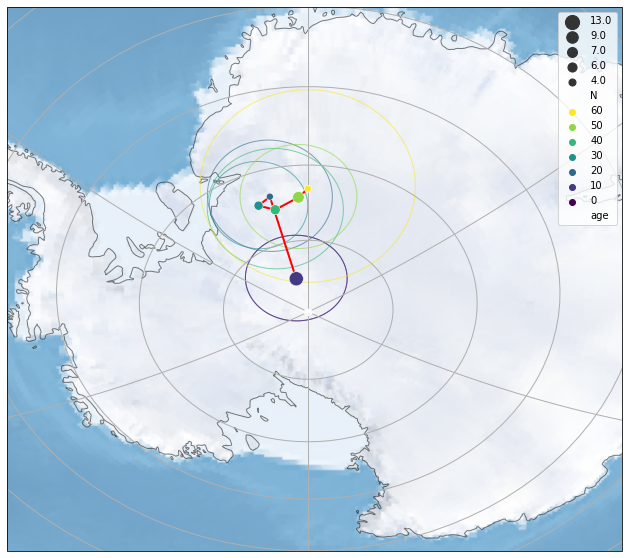

In [11]:
extent = (-180,180,-70,-90)
plot_poles(RM_APWP, 'plon', 'plat', 'A95', 'age', 'N', extent, connect_poles=True)

### Visualize age distribution / resolution
Plot the mean ages and the effective age resolution of the APWP.

In [12]:
def plot_eff_age_dist (data, age_label, id_label, window_length, time_step, max_age, min_age):
    density_dict = {}
    mean_ages = np.arange(min_age, max_age + time_step, time_step)
    for age in mean_ages:
        window_min = age - (window_length / 2.)
        window_max = age + (window_length / 2.)
        density_dict[age] = Counter(data.loc[(data[age_label] >= window_min) & (data[age_label] <= window_max), id_label].tolist())

    fig = plt.figure(figsize=(12, 12))
    gridspec.GridSpec(4,1)
    
    plt.subplot2grid((4,1), (0,0), colspan=1, rowspan=3)
    elinew = 6
    for age, cntr in density_dict.items():
        for poleid, count in cntr.items():
            plt.errorbar(age, poleid+1, yerr=0, xerr=window_length/2, color='r', alpha=count/max(cntr.values()),
                         ecolor=None, elinewidth=elinew, capsize=0, capthick=0, ls='none', label=None, zorder=3)

    for _, row in data.iterrows():
        plt.scatter(row[age_label], row[id_label]+1, color='k', zorder=4)
    
    #plt.yticks(ticks=np.arange(1, data[id_label].max()+2), labels=data[id_label], zorder=1)
    plt.xlim(min_age, max_age)
    plt.grid(color='lightgrey', linestyle='--', linewidth=1, zorder=0) 
    plt.title('Effective age distribution...')

    ages, densities = [], []
    for age, cntr in density_dict.items():
        ages.append(int(age))
        densities.append(sum(cntr.values()))
    
    plt.subplot2grid((4,1), (3,0), colspan=1, rowspan=1)
    plt.bar(ages, densities, width=window_length, color='lightgrey', edgecolor='r', linewidth=1.5, alpha=0.8)
    plt.xlim(min_age, max_age)
    plt.xlabel('Age (Ma)')

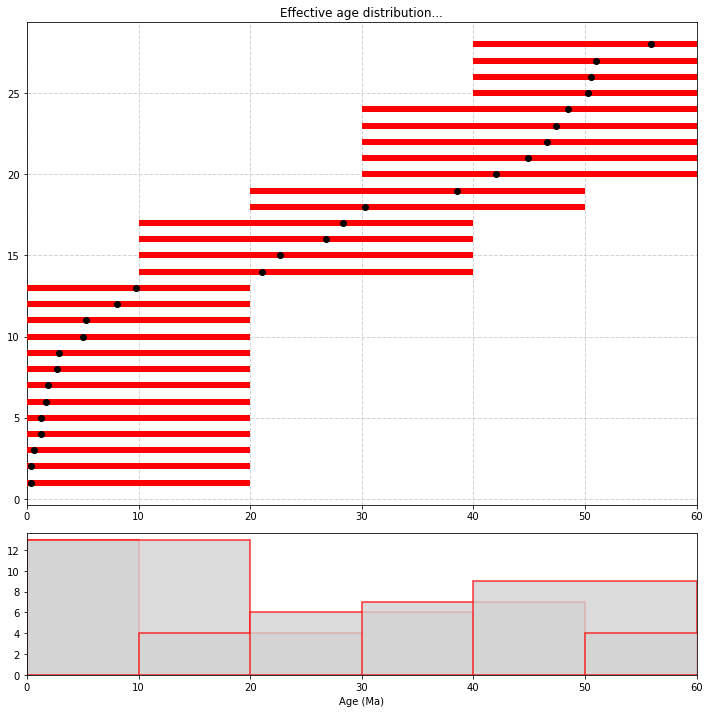

In [13]:
RM_APWP_age_res = plot_eff_age_dist (df_poles, 'mean_age', 'AgeIdx', window_length, time_step, max_age, min_age)

## 2. Moving average using parametrically resampled vgps ('pseudo vgps')

First we need to generate a new dataset by drawing parametrically from the study-level poles.

In [14]:
def get_pseudo_vgps (df):  #column labels are presently hard-coded into this, if relevant.

    poleIDs, age_draws, vgp_lon_draws, vgp_lat_draws = ([] for i in range(4))
    
    for _, ent in df.iterrows():
        
        bootstrap_vgps = ipmag.fishrot(k=ent.K, n=ent.N, dec=ent.Plon, inc=ent.Plat, di_block=False)
        vgp_lon_draws.append(bootstrap_vgps[0])
        vgp_lat_draws.append(bootstrap_vgps[1])
        N = len(bootstrap_vgps[0])
        
        if ent.uncer_dist == 'uniform':
            # first check if bounds of uniform range in fact have normally distributed errors
            
            if np.isnan(ent['2sig_min']): min_ages = [ent.min_age for _ in range(N)]
            else: min_ages = [np.random.normal(loc=ent.min_age, scale=(ent['2sig_min'])/2.) for _ in range(N)]   
            
            if np.isnan(ent['2sig_max']): max_ages = [ent.max_age for _ in range(N)]
            else: max_ages = [np.random.normal(loc=ent.max_age, scale=(ent['2sig_max'])/2.) for _ in range(N)]
            
            # grab uniform draws from range
            age_draws.append([np.random.uniform(min_ages[i], max_ages[i]) for i in range(N)])
            
        elif ent.uncer_dist == 'normal':
            # normal/gaussian draws
            age_draws.append([np.random.normal(loc=ent.mean_age, scale=(ent.max_age - ent.mean_age)/2.) for _ in range(N)]) 
        
        else: print ('unexpected age distribution type; cannot execute age bootstrap')
            
        poleIDs.append([ent.AgeIdx for _ in range(N)])

    bootstrap_data = {'pole_ID': [item for sublist in poleIDs for item in sublist],
                        'plat': [item for sublist in vgp_lat_draws for item in sublist],
                        'plon': [item for sublist in vgp_lon_draws for item in sublist],
                        'age':  [item for sublist in age_draws for item in sublist]}
    
    pseudo_vgps = pd.DataFrame(bootstrap_data)
    
    return pseudo_vgps

In [15]:
pseudo_vgps = get_pseudo_vgps (df_poles)
pseudo_vgps

,pole_ID,plat,plon,age
0,0,-77.534939,199.483390,0.172837
1,0,-67.890285,126.062892,0.586210
2,0,-83.517884,348.905360,0.503331
3,0,-69.264379,313.983620,0.321543
4,0,-78.971451,225.497262,0.477951
...,...,...,...,...
903,27,-65.603954,196.229530,52.590879
904,27,-42.280734,52.225180,53.818995
905,27,-84.793445,311.543633,58.195258
906,27,-81.343798,346.227975,53.460906


### Plot the pseudo vgps (parametric draws from the poles)

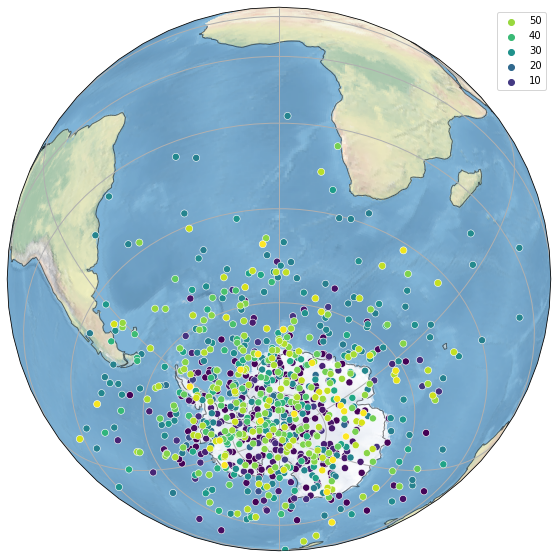

In [16]:
extent = 'global'
plot_poles(pseudo_vgps, 'plon', 'plat', None, 'age', None, extent, plot_A95s=False)

### Compute running means (one realization)

In [17]:
RM_APWP_parametric = running_mean_APWP(pseudo_vgps, 'plon', 'plat', 'age', window_length, time_step, max_age, min_age)
RM_APWP_parametric

,age,N,A95,plon,plat
0,0.0,300.0,1.758518,341.739736,-87.853209
1,10.0,311.0,1.722144,338.559781,-87.721245
2,20.0,211.0,3.367080,356.129336,-79.736321
3,30.0,298.0,2.743358,349.838269,-81.178606
4,40.0,256.0,2.329894,336.710257,-82.838223
5,50.0,299.0,2.170891,349.761070,-82.349913
6,60.0,141.0,3.440672,357.474855,-82.530092


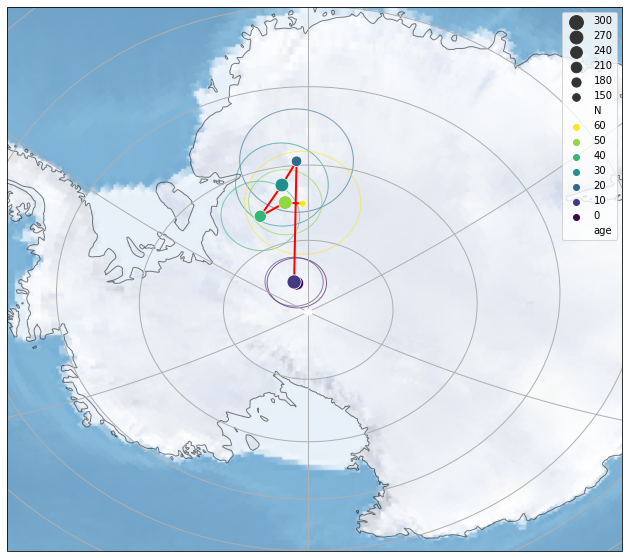

In [18]:
extent = (-180,180,-70,-90)
plot_poles(RM_APWP_parametric, 'plon', 'plat', 'A95', 'age', 'N', extent, connect_poles=True)

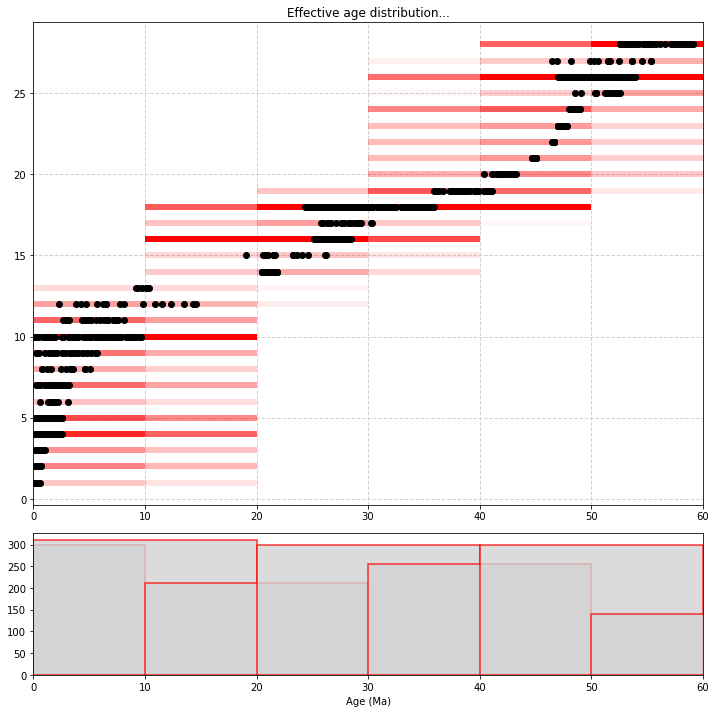

In [19]:
RM_APWP_age_res = plot_eff_age_dist (pseudo_vgps, 'age', 'pole_ID', window_length, time_step, max_age, min_age)

Note that now that we have many more data which are more distributed in time, we can consider shrinking our moving average step and window sizes. 

In [20]:
window_length = 15
time_step = 5
RM_APWP_parametric = running_mean_APWP(pseudo_vgps, 'plon', 'plat', 'age', window_length, time_step, max_age, min_age)
RM_APWP_parametric

,age,N,A95,plon,plat
0,0.0,274.0,1.796584,332.565468,-88.077026
1,5.0,307.0,1.733760,339.313979,-87.611984
2,10.0,137.0,2.737893,314.756225,-87.378780
3,15.0,61.0,3.837328,338.173102,-84.122276
4,20.0,143.0,4.157161,352.702412,-80.906588
5,25.0,233.0,3.232919,357.054834,-80.308517
6,30.0,251.0,3.141990,358.859429,-80.556021
7,35.0,184.0,3.183037,342.031545,-81.563782
8,40.0,151.0,2.872226,331.013199,-82.678506
9,45.0,235.0,2.304543,332.101794,-81.919928


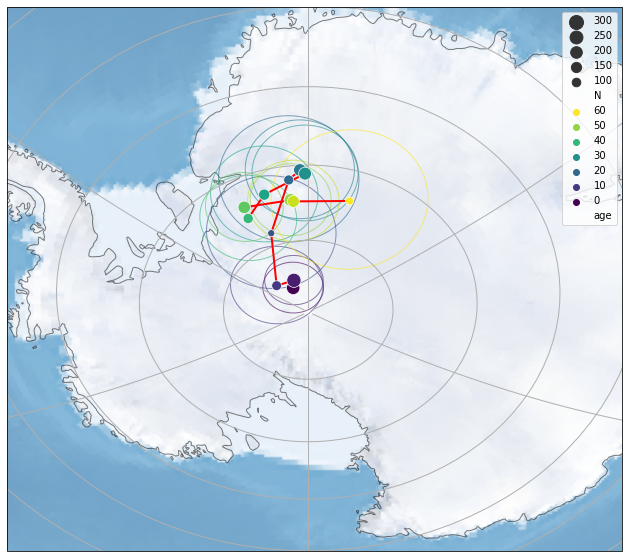

In [21]:
plot_poles(RM_APWP_parametric, 'plon', 'plat', 'A95', 'age', 'N', extent, connect_poles=True)

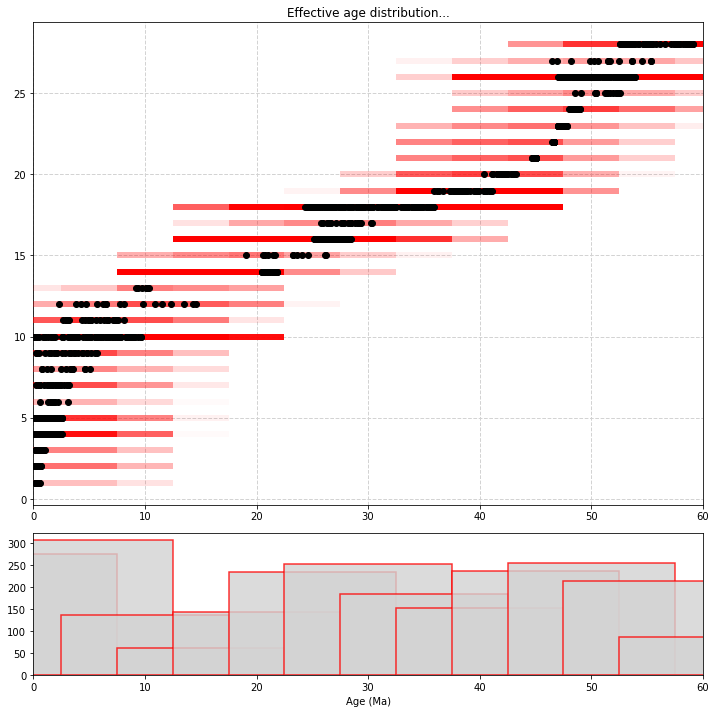

In [22]:
RM_APWP_age_res = plot_eff_age_dist (pseudo_vgps, 'age', 'pole_ID', window_length, time_step, max_age, min_age)

### Compute running means from repeat realizations
While the examples above are illustrative, they are only one realization of parametric draws from the study-level poles. To draw statistically meaningful conclusions we need to repeat this process many times and we can then compute 'means of means'. First we generate multiple realizations and calculate running means each time.

In [23]:
window_length = 15
time_step = 5
df_parametric_means_collection = pd.DataFrame()
for i in range(0, 100):
    pseudo_vgps = get_pseudo_vgps(df_poles)
    RM_APWP_parametric = running_mean_APWP(pseudo_vgps, 'plon', 'plat', 'age', window_length, time_step, max_age, min_age)
    
    if i == 0: df_parametric_means_collection = pd.DataFrame(data=None, columns=RM_APWP_parametric.columns)
    df_parametric_means_collection = df_parametric_means_collection.append(RM_APWP_parametric, ignore_index=True)
    
    

Now we compute the means of these collections of means

,A95,Fisherian,N,age,plat,plon
0,0.201260,True,100.0,0.0,-87.850736,333.797727
1,0.182810,True,100.0,5.0,-87.659945,333.679652
2,0.283187,True,100.0,10.0,-87.310110,303.897740
3,0.355466,True,100.0,15.0,-85.290544,331.827123
4,0.397364,True,100.0,20.0,-81.393159,347.778447
5,0.320260,True,100.0,25.0,-80.811930,348.210077
6,0.317341,True,100.0,30.0,-80.620238,347.225679
7,0.310097,True,100.0,35.0,-81.221560,337.842219
8,0.278505,True,100.0,40.0,-82.129001,336.809581
9,0.235381,True,100.0,45.0,-82.550266,347.475677


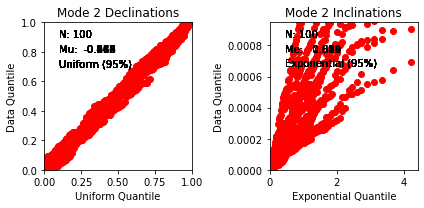

In [24]:
df_overall_parametric_means = pd.DataFrame()
age_groups = df_parametric_means_collection.groupby(['age']) 
for age, group in age_groups:
    
    di_block = list(zip(group['plon'].tolist(), group['plat'].tolist()))
    qqres = ipmag.fishqq(di_block=di_block)
    if qqres[1]['Test_result'] == 'consistent with Fisherian model': Fisherian = 'True' # note fishqq returns an empty dict first for normal vgps (which we don't have)
    else: Fisherian = 'False'
        
    ### qq plots are generated by fishqq function and there doesn't appear to be a kwarg to deactivate them. Is it possible to suppress them?
        
    mean = ipmag.fisher_mean(dec = group['plon'].tolist(), inc = group['plat'].tolist()) # compute mean vgp from among time_units
    
    df_overall_parametric_means = df_overall_parametric_means.append({'age': age, 'plon': mean['dec'], 'plat': mean['inc'], 'A95': mean['alpha95'], \
                                                'N': mean['n'], 'Fisherian': Fisherian}, ignore_index=True)
    
df_overall_parametric_means

Now let's see what we got

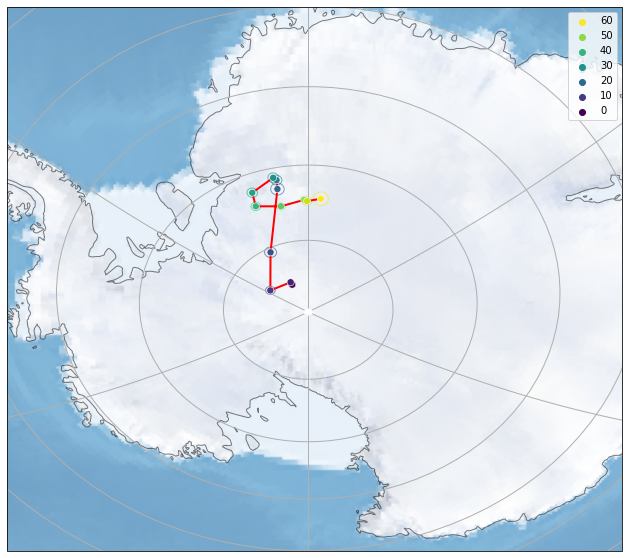

In [25]:
plot_poles(df_overall_parametric_means, 'plon', 'plat', 'A95', 'age', None, extent, connect_poles=True)

## 3. Moving average using original VGPs

First, let's sort the vgps by age and assign them an age-based index as with the poles, and have a look at our data.

In [26]:
df_vgps.sort_values(by='mean_age', ascending=True, inplace=True)
df_vgps.reset_index(drop=True, inplace=True)
df_vgps['AgeIdx'] = np.arange(df_vgps.shape[0])

In [27]:
df_vgps.head()

,name,fm./loc.,slat,slon,n,dec,inc,k,alpha95,f_corr,VGP_lat,VGP_lon,K,A95,dp,dm,mean_age,min_age,2sig_min,max_age,2sig_max,uncer_dist,rock_typ_1,rock_typ_2,rock_typ_3,demag,struc_cont,rot_area,polarity,strat_group,ordering,synch_unit,in_study_pole,rej_crit,pmag_ref,age_ref,pmag_comments,age_comments,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,rev_VGP_lat,rev_VGP_lon,keep,AgeIdx
0,sr16,McKinney Basalt,42.888220,244.92279,7.0,347.4,65.6,227.9,4.0,NaN,79.900000,58.200000,NaN,NaN,NaN,NaN,0.052,0.028,NaN,0.076,NaN,normal,igneous,volcanic,NaN,NaN,NaN,NaN,N,0.0,NaN,0,1,0,Tauxe et al. (2004),Tauxe et al. (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.900000,238.200000,True,0
1,1C684,Sawmill Creek basalt,36.910000,241.69000,8.0,0.4,70.2,248.0,3.5,NaN,72.600000,242.500000,NaN,NaN,NaN,NaN,0.053,0.009,NaN,0.097,NaN,normal,igneous,volcanic,basalt,NaN,NaN,NaN,N,0.0,NaN,0,1,0,Mankinen (2008),Mankinen (2008),NaN,NaN,NaN,NaN,NaN,NaN,NaN,-72.600000,62.500000,True,1
2,S46,Battleship Rock,35.860000,253.36000,9.0,358.3,43.2,317.0,2.9,NaN,79.200000,81.600000,NaN,NaN,NaN,NaN,0.055,0.050,NaN,0.060,NaN,uniform,igneous,volcanic,ash flow,NaN,NaN,NaN,N,1.0,2.0,0,1,0,Doell et al. (1968),Goff et al. (2011),NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.200000,261.600000,True,2
3,5L209,Long Valley Caldera - late basalts and trachya...,NaN,NaN,5.0,338.0,37.6,234.0,5.0,NaN,64.800000,116.300000,NaN,NaN,NaN,NaN,0.064,0.036,NaN,0.092,NaN,normal,igneous,volcanic,basalt,NaN,NaN,NaN,N,0.0,NaN,0,1,0,Mankinen et al. (1986),Mankinen et al. (1986),NaN,K-Ar ages not updated from 1986 standards,NaN,NaN,NaN,NaN,NaN,-64.800000,296.300000,True,3
4,Tan10 (NI 19),Tancitaro volcanics,19.164556,-102.21575,7.0,1.2,32.8,69.0,7.3,NaN,88.269224,36.486753,NaN,NaN,NaN,NaN,0.082,0.058,NaN,0.106,NaN,normal,igneous,volcanic,andesite,NaN,NaN,NaN,N,0.0,NaN,0,1,0,Maciel Peña et al. (2009),Maciel Peña et al. (2009),NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.269224,216.486753,True,4


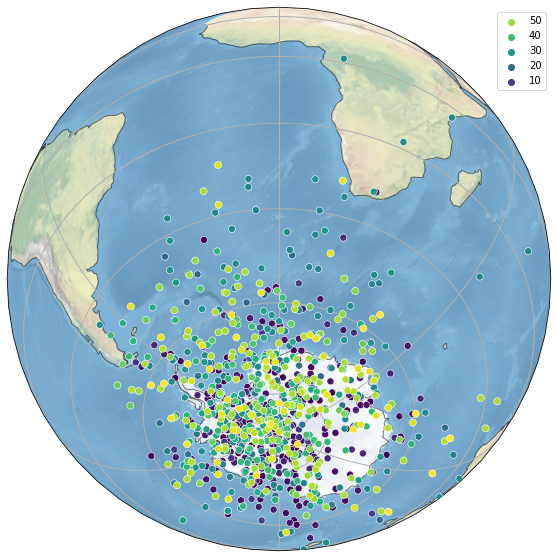

In [28]:
extent = 'global'
plot_poles(df_vgps, 'rev_VGP_lon', 'rev_VGP_lat', None, 'mean_age', None, extent, plot_A95s=False)

Because each vgp is assigned an age, we can construct a moving average APWP as above, but using the vgps directly.

In [29]:
window_length = 15
time_step = 5

RM_APWP_vgps = running_mean_APWP(df_vgps, 'rev_VGP_lon', 'rev_VGP_lat', 'mean_age', window_length, time_step, max_age, min_age)
print (RM_APWP_vgps)

     age      N       A95        plon       plat
0    0.0  279.0  1.749963  329.527042 -88.154169
1    5.0  311.0  1.695412  332.005729 -87.907922
2   10.0  168.0  2.432510  325.380296 -87.178953
3   15.0   75.0  4.011095  347.982154 -82.789019
4   20.0  139.0  4.061936  354.237598 -81.042660
5   25.0  220.0  3.207922  351.825114 -80.140633
6   30.0  253.0  2.829861  343.264143 -81.476014
7   35.0  227.0  2.436854  333.949168 -81.876709
8   40.0  186.0  2.258185  327.396861 -83.348456
9   45.0  271.0  2.167612  347.924712 -82.631642
10  50.0  245.0  2.436418  353.043982 -81.814849
11  55.0  217.0  2.697765  356.780662 -82.010353
12  60.0   62.0  5.657803    1.504064 -81.633048


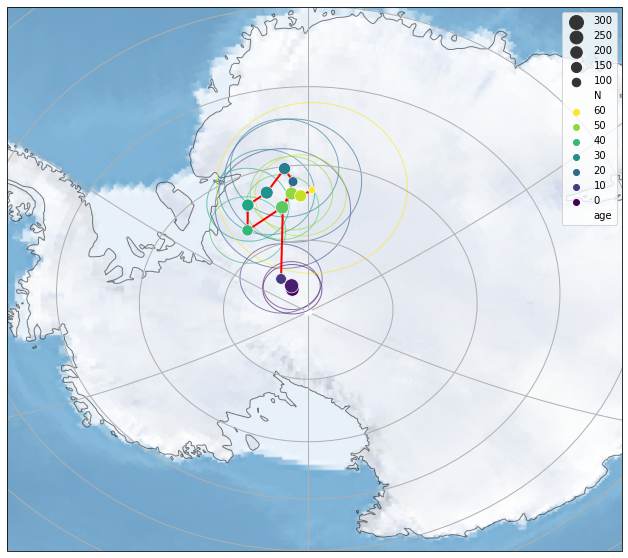

In [30]:
extent = (-180,180,-70,-90)
plot_poles(RM_APWP_vgps, 'plon', 'plat', 'A95', 'age', 'N', extent, connect_poles=True)

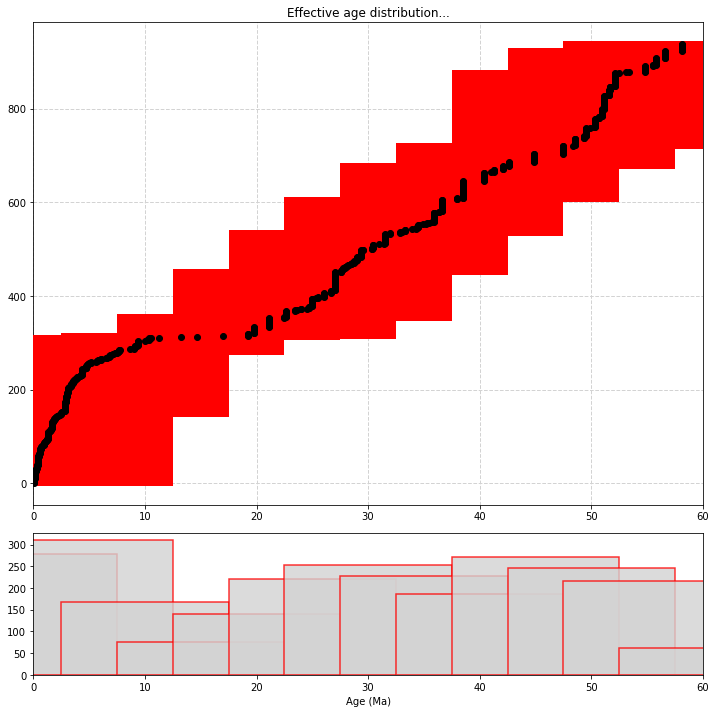

In [31]:
RM_APWP_age_res = plot_eff_age_dist (df_vgps, 'mean_age', 'AgeIdx', window_length, time_step, max_age, min_age)

However, this does not account for the uncertainties in the ages of the vgps. So we can parametrically re-sample from their listed age distributions. Where vgps are stratigraphically-ordered we can also ensure that the drawn ages are consistent with this stratigraphy (**not yet implemented**). And as above, we can repeat this process many times and compute the means of the running means calculated from each realization.

In [32]:
def resample_vgps (df, ignore_deterministic=False):  #column labels are presently hard-coded into this, if relevant.

    poleIDs, age_draws, vgp_lon_draws, vgp_lat_draws = ([] for i in range(4))
    
    # identify any entries for which direction cannot be bootstrapped
    df['deterministic'] = df.apply(lambda row: True if (np.isnan(row.n) | (row.k==0)) else False, axis=1)
    
    if ignore_deterministic == True:
        df.drop(df[df.deterministic == True].index, inplace=True)
    
    # get new directions from all those sites which can be bootstrapped
    for _, ent in df.iterrows():
        
        if ent.deterministic == False:
            bootstrap_dirs = ipmag.fishrot(k=ent.k, n=int(ent.n), dec=ent.dec, inc=ent.inc, di_block=False) # don't need to cast n as int here if ensured above
            if ent.n > 1:
                mean_dir = ipmag.fisher_mean(dec=bootstrap_dirs[0], inc=bootstrap_dirs[1])
                new_vgp = pmag.dia_vgp(mean_dir['dec'], mean_dir['inc'], mean_dir['alpha95'], ent.slat, ent.slon)
            else: 
                new_vgp = pmag.dia_vgp(bootstrap_dirs[0], bootstrap_dirs[1], 0, ent.slat, ent.slon)
            
            if ent.polarity == 'R':  # should probably make a new column of re-assigned polarities in build_compilation notebook (else need to over-write the non-N/R options reported by authors...)?
                vgp_lon_draws.append(new_vgp[0])
                vgp_lat_draws.append(new_vgp[1])
            else:
                vgp_lon_draws.append((new_vgp[0]- 180.) % 360.)
                vgp_lat_draws.append(new_vgp[1] * -1)
        
        if ent.deterministic == True: # this only applies when ignore_deterministic == False
            vgp_lon_draws.append(ent.rev_VGP_lon)
            vgp_lat_draws.append(ent.rev_VGP_lat)
        
        if ent.uncer_dist == 'uniform':
            # first check if bounds of uniform range in fact have normally distributed errors
            
            if np.isnan(ent['2sig_min']): min_ages = ent.min_age
            else: min_ages = np.random.normal(loc=ent.min_age, scale=(ent['2sig_min'])/2.)   
            
            if np.isnan(ent['2sig_max']): max_ages = ent.max_age
            else: max_ages = np.random.normal(loc=ent.max_age, scale=(ent['2sig_max'])/2.)
            
            # grab uniform draws from range
            age_draws.append(np.random.uniform(min_ages, max_ages))
            
        elif ent.uncer_dist == 'normal':
            # normal/gaussian draws
            age_draws.append(np.random.normal(loc=ent.mean_age, scale=(ent.max_age - ent.mean_age)/2.)) 
        
        else: print ('unexpected age distribution type; cannot execute age bootstrap')
        
         # *** NEED TO IMPLEMENT AGE SORTING ACCORDING TO STRATIGRAPHIC ORDERING ***
            
        poleIDs.append(ent.AgeIdx)

    bootstrap_data = {'pole_ID': poleIDs,
                      'plat': vgp_lat_draws,
                      'plon': vgp_lon_draws,
                      'age': age_draws}
    
    resampled_vgps = pd.DataFrame(bootstrap_data)
    
    return resampled_vgps

In [ ]:
window_length = 15
time_step = 5
df_nonparametric_means_collection = pd.DataFrame()
for i in range(0, 100):
    resampled_vgps = resample_vgps(df_vgps)
    RM_APWP_nonparametric = running_mean_APWP(resampled_vgps, 'plon', 'plat', 'age', window_length, time_step, max_age, min_age)
    
    if i == 0: df_nonparametric_means_collection = pd.DataFrame(data=None, columns=RM_APWP_nonparametric.columns)
    df_nonparametric_means_collection = df_nonparametric_means_collection.append(RM_APWP_nonparametric, ignore_index=True)

In [ ]:
df_overall_nonparametric_means = pd.DataFrame()
age_groups = df_nonparametric_means_collection.groupby(['age']) 
for age, group in age_groups:
    
    di_block = list(zip(group['plon'].tolist(), group['plat'].tolist()))
    qqres = ipmag.fishqq(di_block=di_block)
    if qqres[1]['Test_result'] == 'consistent with Fisherian model': Fisherian = 'True' # note fishqq returns an empty dict first for normal vgps (which we don't have)
    else: Fisherian = 'False'
        
    ### qq plots are generated by fishqq function and there doesn't appear to be a kwarg to deactivate them. Is it possible to suppress them?
        
    mean = ipmag.fisher_mean(dec = group['plon'].tolist(), inc = group['plat'].tolist()) # compute mean vgp from among time_units
    
    df_overall_nonparametric_means = df_overall_nonparametric_means.append({'age': age, 'plon': mean['dec'], 'plat': mean['inc'], 'A95': mean['alpha95'], \
                                                'N': mean['n'], 'Fisherian': Fisherian}, ignore_index=True)
    
df_overall_nonparametric_means

In [ ]:
plot_poles(df_overall_nonparametric_means, 'plon', 'plat', 'A95', 'age', None, extent, connect_poles=True)